# Tips, Tricks, and Troubleshooting

This notebook highlights some useful things to know when working with PyImageJ.

In [1]:
import imagej
ij = imagej.init('net.imagej:imagej:2.1.0')
ij.getVersion()

'2.1.0/1.53c'

## Technical note for using ops on numpy arrays

Remember that NumPy arrays become `RandomAccessibleInterval`s and can substitute for `IterableInterval`s using `Views`.

In [2]:
import numpy as np
arr1 = np.array([[1, 2], [3, 4]])
print(type(ij.py.to_java(arr1)))

<java class 'net.imglib2.python.ReferenceGuardingRandomAccessibleInterval'>


If you need to troubleshoot op workings, look for implementations that use only `IterableInterval`s or `RandomAccessibleInterval`s. To find the implementations use the `print(ij.op().help())` function.

For the multiply function the implementation we used is second to last (`net.imagej.ops.math.IIToRAIOutputII$Multiply`)

In [3]:
# print is required to render new lines
print(ij.op().help('multiply'))

Available operations:
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyByte(
		ArrayImg arg,
		byte value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyDouble(
		ArrayImg arg,
		double value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyFloat(
		ArrayImg arg,
		float value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyInt(
		ArrayImg arg,
		int value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyLong(
		ArrayImg arg,
		long value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyShort(
		ArrayImg arg,
		short value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyUnsignedByte(
		ArrayImg arg,
		byte value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyUnsignedInt(
		ArrayImg arg,
		int value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyUnsignedLong(
		ArrayImg arg,
		long value)
	(Arr

Any `Op` that requires a `RandomAccessibleInterval` can run on a numpy array that has been passed to `to_java`.  Remember that this method creates a `view`, meaning that the `Op` is **modifying** the underlying Python object:

Let's run a [Difference of Gaussians](https://en.wikipedia.org/wiki/Difference_of_Gaussians) on our numpy image using ImageJ:

## ij.py convenience methods

These methods can be helpful, especially if you do not know beforehand of which type your image is.

### ij.py.dims
This can be used to determine the dimensions of a numpy **or** ImageJ image:

In [4]:
# numpy image
img1 = np.zeros([10, 10])
print(ij.py.dims(img1))

# imagej image
img2 = ij.py.to_java(img1)
print(ij.py.dims(img2))

(10, 10)
[10, 10]


### ij.py.new_numpy_image

Takes a single image argument, which can either be a numpy image or an imagej image

In [5]:
# create a new numpy image from a numpy image
img3 = ij.py.new_numpy_image(img1)
print(type(img3))

# create a new numpy image from an imagej image
img4 = ij.py.new_numpy_image(img2)
print(type(img4))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### ij.py.jargs

In [6]:
print('TODO')

TODO


## Troubleshooting

### I can't pass my numpy image to an ImageJ op

`ij.py` is really good at converting numpy images into `RandomAccessibleInterval`s. However many ImageJ ops, like `addPoissonNoise`, take other forms of ImageJ images, like `IterableInterval`.

In [7]:
print(ij.op().help('filter.addPoissonNoise'))

Available operations:
	(RealType out) =
	net.imagej.ops.filter.addPoissonNoise.AddPoissonNoiseRealType(
		RealType out,
		RealType in,
		long seed?)
	(IterableInterval out) =
	net.imagej.ops.filter.addPoissonNoise.AddPoissonNoiseMap(
		IterableInterval out,
		IterableInterval in)


We can't call this `Op` on a numpy array since it is a specialized type of `RandomAccessibleInterval`, which does not extend `IterableInterval`.

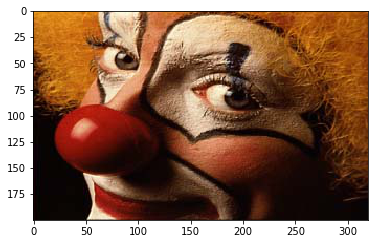

<java class 'net.imglib2.python.ReferenceGuardingRandomAccessibleInterval'>


In [8]:
from skimage import io
img = io.imread('https://imagej.net/images/clown.jpg')

ij.py.show(img)
print(type(ij.py.to_java(img)))

__Try It!__

Try adding noise to this fellow. Uncomment the following line and see what happens!

In [9]:
#ij.op().filter().addPoissonNoise(ij.py.to_java(img))

We can fix this by using `transform.flatIterableView` on both the input and output, which will convert the `ReferenceGuardedRandomAccessibleInterval`s into `IterableInterval`s, allowing us to pass our numpy image into `addPoissonNoise`:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


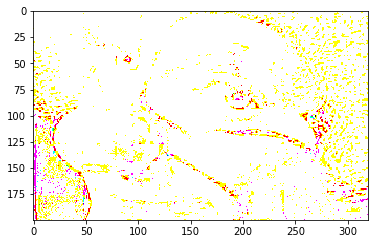

In [10]:
import numpy as np
result = np.zeros(img.shape) # NB: dtype of float32 enables more accurate noise :P

imgIterable = ij.op().transform().flatIterableView(ij.py.to_java(img))
resIterable = ij.op().transform().flatIterableView(ij.py.to_java(result))

ij.op().filter().addPoissonNoise(resIterable, imgIterable)

ij.py.show(result)

Uh oh.

### Clipping input data to the valid range
This message is given either because (as described in the warning)

* The data consists of floats that are outside the range of [0..1]. This is pretty common and definitely is the case as to why the above data looks so bad.
* The data consists of ints that are outside the range [0..255].

Let's find out which is the culprit by checking some values of `result`:

In [11]:
# grab the RGB values in a line from [0][5] to [0][10] in our image
print(result[0][5:10])

[[243. 179.  37.]
 [265. 155.  47.]
 [261. 174.  46.]
 [250. 177.  39.]
 [229. 181.  50.]]


Thus we not only have floats outside of [0..1] but also values outside of [0..255]; we are faulty of both points in the warning. We can fix this by first [clipping](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.clip.html) the entire array within the integer range, then cast to `uint8` so that the float range no longer applies:

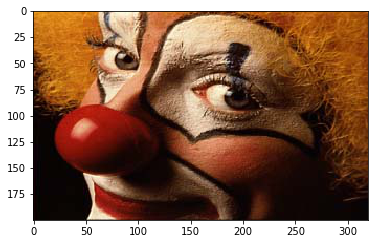

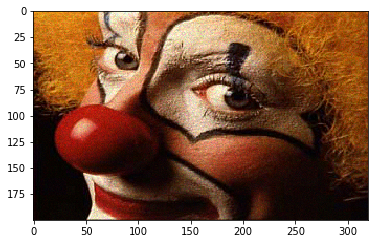

In [12]:
ij.py.show(img.astype(int))
       
result = np.clip(result, 0, 255)
ij.py.show(result.astype(np.uint8))

Now our noisy image displays nicely alongside the original. Note that depending on your data this might not be the right path for you, but using `clip` and `astype` are great tools for rearranging your data within these bounds.